# Import the libraries

In [495]:
import pandas as pd
import numpy as np


from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split

import pickle as pk

from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import VarianceThreshold

from sklearn import metrics

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Import the data

In [496]:
house_prices = pd.read_csv("house_prices_dataframe.csv")
house_prices.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,property_typ
0,221900,3,1.00,1180,5650,1.0,no,bad,3,7.0,0,1955,0.0,apartment
1,538000,3,2.25,2570,7242,2.0,no,bad,3,7.0,400,1951,1991.0,semi_detached_house
2,180000,2,1.00,770,10000,1.0,no,bad,3,6.0,0,1933,NaN,apartment
3,604000,4,3.00,1960,5000,1.0,no,bad,5,7.0,910,1965,NaN,semi_detached_house
4,510000,3,2.00,1680,8080,1.0,no,bad,3,8.0,0,1987,0.0,apartment


In [497]:
house_prices.shape

(21613, 14)

In [498]:
house_prices.dtypes

price              int64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront        object
view              object
condition          int64
grade            float64
sqft_basement      int64
yr_built           int64
yr_renovated     float64
property_typ      object
dtype: object

# Answering Research Questions - Descriptive Statistics

In [499]:
'''
The further procedure follows the Best Practice approach for ML Model Development. 
I have listed this approach at the end of this publication. 
It allows you to track the naming convention used and to see when which models, data sets or stored metrics are saved. 
'''

'\nThe further procedure follows the Best Practice approach for ML Model Development. \nI have listed this approach at the end of this publication. \nIt allows you to track the naming convention used and to see when which models, data sets or stored metrics are saved. \n'

## Data pre-processing

### Check for outliers

In [500]:
'''
First we will check the data frame for some outliers.
This step is necessary first, because otherwise replacing missing values would be negatively affected.
Categorical variables are not considered by this step.
'''

'\nFirst we will check the data frame for some outliers.\nThis step is necessary first, because otherwise replacing missing values would be negatively affected.\nCategorical variables are not considered by this step.\n'

In [501]:
'''
For the identification of outliers the z-score method is used.

In statistics, if a data distribution is approximately normal then about 68% 
of the data points lie within one standard deviation (sd) of the mean and about 95% 
are within two standard deviations, and about 99.7% lie within three standard deviations.

Therefore, if you have any data point that is more than 3 times the standard deviation, 
then those points are very likely to be outliers.

We are going to check observations above a sd of 3 and remove these as an outlier. 
'''

'\nFor the identification of outliers the z-score method is used.\n\nIn statistics, if a data distribution is approximately normal then about 68% \nof the data points lie within one standard deviation (sd) of the mean and about 95% \nare within two standard deviations, and about 99.7% lie within three standard deviations.\n\nTherefore, if you have any data point that is more than 3 times the standard deviation, \nthen those points are very likely to be outliers.\n\nWe are going to check observations above a sd of 3 and remove these as an outlier. \n'

In [502]:
'''
Here I defined a function do identificate observations with an sd above 3.
'''

def outliers_z_score(df):
    threshold = 3

    mean = np.mean(df)
    std = np.std(df)
    z_scores = [(y - mean) / std for y in df]
    return np.where(np.abs(z_scores) > threshold)

In [503]:
'''
For the further proceeding we just need numerical colunns.
'''

my_list = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_columns = list(house_prices.select_dtypes(include=my_list).columns)
numerical_columns = house_prices[num_columns]
numerical_columns.head(3)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_basement,yr_built,yr_renovated
0,221900,3,1.00,1180,5650,1.0,3,7.0,0,1955,0.0
1,538000,3,2.25,2570,7242,2.0,3,7.0,400,1951,1991.0
2,180000,2,1.00,770,10000,1.0,3,6.0,0,1933,NaN


In [504]:
'''
Now we are going to apply our outlier-function to all numerical columns
'''

outlier_list = numerical_columns.apply(lambda x: outliers_z_score(x))
outlier_list

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_basement,yr_built,yr_renovated
0,"[21, 153, 246, 269, 282, 300, 312, 518, 540, 5...","[556, 875, 1135, 1241, 1660, 3119, 3467, 3721,...","[5, 270, 300, 450, 527, 1055, 1100, 1122, 1163...","[5, 153, 269, 270, 419, 436, 484, 486, 527, 54...","[145, 199, 238, 380, 411, 416, 419, 443, 484, ...","[875, 10077, 11594, 14885, 15424, 18477, 20308...","[36, 380, 397, 1442, 1734, 2223, 3004, 3202, 3...","[153, 350, 419, 465, 540, 722, 799, 1066, 1149...","[10, 41, 70, 153, 185, 218, 239, 246, 300, 556...",[],[]


In [505]:
df_of_outlier = outlier_list.iloc[0]
df_of_outlier = pd.DataFrame(df_of_outlier)
df_of_outlier.columns = ['Rows_to_exclude']
df_of_outlier

,Rows_to_exclude
price,"[21, 153, 246, 269, 282, 300, 312, 518, 540, 5..."
bedrooms,"[556, 875, 1135, 1241, 1660, 3119, 3467, 3721,..."
bathrooms,"[5, 270, 300, 450, 527, 1055, 1100, 1122, 1163..."
sqft_living,"[5, 153, 269, 270, 419, 436, 484, 486, 527, 54..."
sqft_lot,"[145, 199, 238, 380, 411, 416, 419, 443, 484, ..."
floors,"[875, 10077, 11594, 14885, 15424, 18477, 20308..."
condition,"[36, 380, 397, 1442, 1734, 2223, 3004, 3202, 3..."
grade,"[153, 350, 419, 465, 540, 722, 799, 1066, 1149..."
sqft_basement,"[10, 41, 70, 153, 185, 218, 239, 246, 300, 556..."
yr_built,[]


In [506]:

# Convert all values from column Rows_to_exclude to a numpy array
outlier_list_final = df_of_outlier['Rows_to_exclude'].to_numpy()

# Concatenate a whole sequence of arrays
outlier_list_final = np.concatenate( outlier_list_final, axis=0 )

# Drop dubplicate values
outlier_list_final_unique = set(outlier_list_final)
outlier_list_final_unique

{18432,
 4096,
 4098,
 8195,
 4099,
 16389,
 5,
 12295,
 12298,
 18443,
 14348,
 10,
 4111,
 8208,
 12306,
 20499,
 20500,
 21,
 4118,
 10263,
 18455,
 6167,
 18460,
 10268,
 8222,
 6174,
 10275,
 36,
 2085,
 2088,
 41,
 10283,
 18477,
 16430,
 20527,
 14385,
 18482,
 6195,
 4149,
 6197,
 20535,
 20534,
 12350,
 14398,
 16448,
 2113,
 2112,
 70,
 8266,
 6219,
 2125,
 12365,
 18511,
 10318,
 12370,
 14419,
 20563,
 14423,
 2136,
 6233,
 12375,
 10331,
 2140,
 18519,
 4190,
 20578,
 12387,
 6244,
 16488,
 8297,
 4218,
 18556,
 20607,
 16514,
 2179,
 10373,
 14681,
 8329,
 4235,
 16525,
 6287,
 14480,
 10385,
 145,
 16530,
 2200,
 153,
 8344,
 6297,
 4255,
 18594,
 12453,
 8362,
 12459,
 4268,
 4267,
 10413,
 12460,
 2223,
 14513,
 4274,
 20664,
 185,
 2236,
 6335,
 10431,
 18626,
 16580,
 199,
 4300,
 10446,
 18645,
 14550,
 10456,
 10458,
 2267,
 14556,
 12509,
 218,
 10465,
 2273,
 10468,
 16614,
 4332,
 238,
 239,
 4339,
 6389,
 246,
 6390,
 6392,
 20727,
 14581,
 8443,
 8191,
 6402,


In [507]:
'''
Now we are going to exclude the identified outliers from original dataframe.
'''


filter_rows_to_exclude = house_prices.index.isin(outlier_list_final_unique)
df_without_outliers = house_prices[~filter_rows_to_exclude]

In [508]:
print('Length of original dataframe: ' + str(len(house_prices)))

print('Length of new dataframe without outliers: ' + str(len(df_without_outliers)))
print('----------------------------------------------------------------------------------------------------')
print('Difference between new and old dataframe: ' + str(len(house_prices) - len(df_without_outliers)))
print('----------------------------------------------------------------------------------------------------')
print('Length of unique outlier list: ' + str(len(outlier_list_final_unique)))

Length of original dataframe: 21613
Length of new dataframe without outliers: 20435
----------------------------------------------------------------------------------------------------
Difference between new and old dataframe: 1178
----------------------------------------------------------------------------------------------------
Length of unique outlier list: 1178


In [509]:
'''
Important!
If you look at the index of the last two columns, you will notice that index 5 is missing. 
This is because the values from row 5 for the variables bathrooms and sqft_living 
were identified as outlier and removed accordingly. 

The data set now has 1178 (the number of unique outliers) gaps at the corresponding position in the index. 
This can lead to problems if you want to join other tables via the index. 

Since I know that this will be the case as soon as I encode the categorical variables, 
I proactively create a new index (via reset_index function) which will allow me to easily add new records later.

Below you can see the difference between index and new_index.
'''

df_without_outliers = df_without_outliers.reset_index()

df_without_outliers = df_without_outliers.rename(columns={'index':'old_index'})

df_without_outliers.head(6)

,old_index,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,property_typ
0,0,221900,3,1.00,1180,5650,1.0,no,bad,3,7.0,0,1955,0.0,apartment
1,1,538000,3,2.25,2570,7242,2.0,no,bad,3,7.0,400,1951,1991.0,semi_detached_house
2,2,180000,2,1.00,770,10000,1.0,no,bad,3,6.0,0,1933,NaN,apartment
3,3,604000,4,3.00,1960,5000,1.0,no,bad,5,7.0,910,1965,NaN,semi_detached_house
4,4,510000,3,2.00,1680,8080,1.0,no,bad,3,8.0,0,1987,0.0,apartment
5,6,257500,3,2.25,1715,6819,2.0,no,bad,3,7.0,0,1995,NaN,apartment


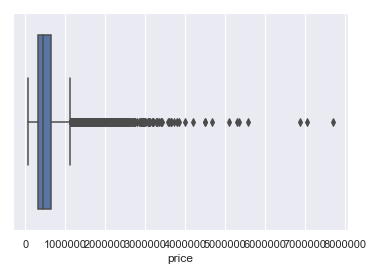

In [510]:

sns.boxplot(x='price', data=house_prices)

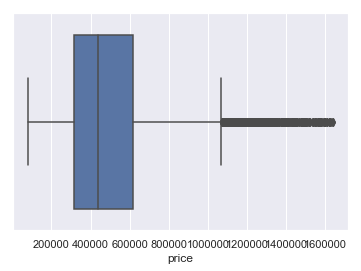

In [511]:

sns.boxplot(x='price', data=df_without_outliers)

### Check for Missing Values

In [512]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [513]:
missing_values_table(df_without_outliers)

Your selected dataframe has 15 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
yr_renovated,15732,77.0
grade,110,0.5


In [514]:
'''
Delete the column yr_renovated

Due to the high number of missing values (>75%) 
the column yr_renovated should not be considered in the further analysis. 
'''

df_without_outliers = df_without_outliers.drop(['yr_renovated'], axis=1)
df_without_outliers.head()

,old_index,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,property_typ
0,0,221900,3,1.00,1180,5650,1.0,no,bad,3,7.0,0,1955,apartment
1,1,538000,3,2.25,2570,7242,2.0,no,bad,3,7.0,400,1951,semi_detached_house
2,2,180000,2,1.00,770,10000,1.0,no,bad,3,6.0,0,1933,apartment
3,3,604000,4,3.00,1960,5000,1.0,no,bad,5,7.0,910,1965,semi_detached_house
4,4,510000,3,2.00,1680,8080,1.0,no,bad,3,8.0,0,1987,apartment


In [515]:
'''
Impute missing values for column grade

Due to the low number of Missing Values within the grade column, 
this column will not be deleted as valuable information could be lost.
The missing values should be filled with the mean value of the column instead.
'''


df_without_outliers['grade'] = df_without_outliers['grade'].fillna(df_without_outliers['grade'].mean())

In [516]:
'''
Check if all missing values are removed or replaced.
'''

missing_values_table(df_without_outliers)

Your selected dataframe has 14 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [517]:
'''
According to our best practice approach we will assign a new name to the data set.
'''

df_without_MV = df_without_outliers

### Handling Categorical Variables

In [518]:
obj_col = ['object']
object_columns = list(df_without_MV.select_dtypes(include=obj_col).columns)
house_prices_categorical = df_without_MV[object_columns]

print()
print('There are ' + str(house_prices_categorical.shape[1]) + ' categorical columns within dataframe:')

house_prices_categorical.head()


There are 3 categorical columns within dataframe:


,waterfront,view,property_typ
0,no,bad,apartment
1,no,bad,semi_detached_house
2,no,bad,apartment
3,no,bad,semi_detached_house
4,no,bad,apartment


In [519]:
print('Values of the variable waterfront:')
print()
print(df_without_MV['waterfront'].value_counts())

print('--------------------------------------------')

print('Values of the variable view:')
print()
print(df_without_MV['view'].value_counts())

print('--------------------------------------------')

print('Values of the variable property_typ:')
print()
print(df_without_MV['property_typ'].value_counts())

Values of the variable waterfront:

no     20351
yes       84
Name: waterfront, dtype: int64
--------------------------------------------
Values of the variable view:

bad          18760
good           819
very_good      385
medium         290
excellent      181
Name: view, dtype: int64
--------------------------------------------
Values of the variable property_typ:

apartment                 12454
semi_detached_house        6617
single_family_house        1084
top_floor_apartment         147
multi_generation_house      133
Name: property_typ, dtype: int64


In [520]:
'''
Based on the output shown above,
the following scale level can be determined for the three categorical variables:

waterfront: binary
view: ordinal
property_typ: nominal

The variables will be coded accordingly in the following.
'''

'\nBased on the output shown above,\nthe following scale level can be determined for the three categorical variables:\n\nwaterfront: binary\nview: ordinal\nproperty_typ: nominal\n\nThe variables will be coded accordingly in the following.\n'

In [521]:
'''
In the following the column waterfront is coded.
Then the newly generated values are inserted into the original dataframe 
and the old column will be deleted. 
'''

encoder_waterfront = LabelBinarizer()

# Application of the LabelBinarizer
waterfront_encoded = encoder_waterfront.fit_transform(df_without_MV.waterfront.values.reshape(-1,1))

# Insertion of the coded values into the original data set
df_without_MV['waterfront_encoded'] = waterfront_encoded

# Delete the original column to avoid duplication
df_without_MV = df_without_MV.drop(['waterfront'], axis=1)

# Getting the exact coding and show new dataframe
print(encoder_waterfront.classes_)
print('Codierung: no=0, yes=1')
print('-----------------------------')
print()
print('New Data Frame:')
df_without_MV.head()

['no' 'yes']
Codierung: no=0, yes=1
-----------------------------

New Data Frame:


,old_index,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_basement,yr_built,property_typ,waterfront_encoded
0,0,221900,3,1.00,1180,5650,1.0,bad,3,7.0,0,1955,apartment,0
1,1,538000,3,2.25,2570,7242,2.0,bad,3,7.0,400,1951,semi_detached_house,0
2,2,180000,2,1.00,770,10000,1.0,bad,3,6.0,0,1933,apartment,0
3,3,604000,4,3.00,1960,5000,1.0,bad,5,7.0,910,1965,semi_detached_house,0
4,4,510000,3,2.00,1680,8080,1.0,bad,3,8.0,0,1987,apartment,0


In [522]:
'''
In the following the column view is coded.
Then the newly generated values are inserted into the original dataframe 
and the old column will be deleted. 
'''

# Create a dictionary how the observations should be coded
view_dict = {'bad' : 0,
             'medium' : 1,
             'good' : 2,
             'very_good' : 3,
             'excellent' : 4}

# Map the dictionary on the column view and store the results in a new column
df_without_MV['view_encoded'] = df_without_MV.view.map(view_dict)

# Delete the original column to avoid duplication
df_without_MV = df_without_MV.drop(['view'], axis=1)


print('New Data Frame:')
df_without_MV.head()

New Data Frame:


,old_index,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_basement,yr_built,property_typ,waterfront_encoded,view_encoded
0,0,221900,3,1.00,1180,5650,1.0,3,7.0,0,1955,apartment,0,0
1,1,538000,3,2.25,2570,7242,2.0,3,7.0,400,1951,semi_detached_house,0,0
2,2,180000,2,1.00,770,10000,1.0,3,6.0,0,1933,apartment,0,0
3,3,604000,4,3.00,1960,5000,1.0,5,7.0,910,1965,semi_detached_house,0,0
4,4,510000,3,2.00,1680,8080,1.0,3,8.0,0,1987,apartment,0,0


In [523]:
'''
In the following the column property_typ is coded.
Then the newly generated values are inserted into the original dataframe 
and the old column will be deleted. 
'''

encoder_property_typ = OneHotEncoder()

# Application of the OneHotEncoder
OHE = encoder_property_typ.fit_transform(df_without_MV.property_typ.values.reshape(-1,1)).toarray()

# Conversion of the newly generated data to a dataframe
df_OHE = pd.DataFrame(OHE, columns = ["property_typ_" + str(encoder_property_typ.categories_[0][i]) 
                                     for i in range(len(encoder_property_typ.categories_[0]))])




# Insertion of the coded values into the original data set
df_without_MV = pd.concat([df_without_MV, df_OHE], axis=1)


# Delete the original column to avoid duplication
df_without_MV = df_without_MV.drop(['property_typ'], axis=1)


print('New Data Frame:')
df_without_MV.head()

New Data Frame:


,old_index,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_basement,yr_built,waterfront_encoded,view_encoded,property_typ_apartment,property_typ_multi_generation_house,property_typ_semi_detached_house,property_typ_single_family_house,property_typ_top_floor_apartment
0,0,221900,3,1.00,1180,5650,1.0,3,7.0,0,1955,0,0,1.0,0.0,0.0,0.0,0.0
1,1,538000,3,2.25,2570,7242,2.0,3,7.0,400,1951,0,0,0.0,0.0,1.0,0.0,0.0
2,2,180000,2,1.00,770,10000,1.0,3,6.0,0,1933,0,0,1.0,0.0,0.0,0.0,0.0
3,3,604000,4,3.00,1960,5000,1.0,5,7.0,910,1965,0,0,0.0,0.0,1.0,0.0,0.0
4,4,510000,3,2.00,1680,8080,1.0,3,8.0,0,1987,0,0,1.0,0.0,0.0,0.0,0.0


In [524]:
'''

Now that the record is clean we can rename it accordingly.
It is also recommended to save the clean data set at this point.
'''

final_df_house_prices = df_without_MV

final_df_house_prices.to_csv('dataframes/final_df_house_prices.csv', index=False)

## Reserach Question 1

In [525]:
'''

Is there a difference in the characteristics of the properties,
if they are located on a waterfront?

'''

'\n\nIs there a difference in the characteristics of the properties,\nif they are located on a waterfront?\n\n'

In [526]:
print('Absolute distribution: ')
print()
print(final_df_house_prices['waterfront_encoded'].value_counts())

print('-------------------------------------------------------')

print('Percentage distribution: ')
print()
print(pd.DataFrame({'Percentage': final_df_house_prices.groupby(('waterfront_encoded')).size() / len(final_df_house_prices)}))

Absolute distribution: 

0    20351
1       84
Name: waterfront_encoded, dtype: int64
-------------------------------------------------------
Percentage distribution: 

                    Percentage
waterfront_encoded            
0                     0.995889
1                     0.004111


In [527]:
final_df_house_prices.groupby(('waterfront_encoded')).mean()

,old_index,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_basement,yr_built,view_encoded,property_typ_apartment,property_typ_multi_generation_house,property_typ_semi_detached_house,property_typ_single_family_house,property_typ_top_floor_apartment
waterfront_encoded,,,,,,,,,,,,,,,,,
0,10805.697361,495537.185789,3.331089,2.057860,1983.184807,10558.674217,1.48376,3.412854,7.576752,266.081028,1970.737949,0.171736,0.610142,0.006535,0.323768,0.052528,0.007027
1,10724.261905,883305.857143,2.809524,2.074405,2136.380952,22005.107143,1.50000,3.583333,7.678571,418.773810,1952.428571,3.714286,0.440476,0.000000,0.333333,0.178571,0.047619


In [528]:
'''
The average price for waterfront properties is almost twice as high as for other properties.

In contrast, however, plots without a water front have on average more square meters of living space and usable area. 
Also in terms of condition and degree they are a little better off. 

If one regards the year of construction of the real estates then one 
can state that the houses at a waterfront are average 18 years older.
'''

'\nThe average price for waterfront properties is almost twice as high as for other properties.\n\nIn contrast, however, plots without a water front have on average more square meters of living space and usable area. \nAlso in terms of condition and degree they are a little better off. \n\nIf one regards the year of construction of the real estates then one \ncan state that the houses at a waterfront are average 18 years older.\n'

## Reserach Question 2

In [529]:
'''

What clusters are there in terms of real estate?

'''

'\n\nWhat clusters are there in terms of real estate?\n\n'

In [530]:
# Here we drop the column old_index because we do not want to cluster these features

house_prices_cluster = final_df_house_prices.drop(['old_index'], axis=1)
house_prices_cluster

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_basement,yr_built,waterfront_encoded,view_encoded,property_typ_apartment,property_typ_multi_generation_house,property_typ_semi_detached_house,property_typ_single_family_house,property_typ_top_floor_apartment
0,221900,3,1.00,1180,5650,1.0,3,7.0,0,1955,0,0,1.0,0.0,0.0,0.0,0.0
1,538000,3,2.25,2570,7242,2.0,3,7.0,400,1951,0,0,0.0,0.0,1.0,0.0,0.0
2,180000,2,1.00,770,10000,1.0,3,6.0,0,1933,0,0,1.0,0.0,0.0,0.0,0.0
3,604000,4,3.00,1960,5000,1.0,5,7.0,910,1965,0,0,0.0,0.0,1.0,0.0,0.0
4,510000,3,2.00,1680,8080,1.0,3,8.0,0,1987,0,0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20430,360000,3,2.50,1530,1131,3.0,3,8.0,0,2009,0,0,1.0,0.0,0.0,0.0,0.0
20431,400000,4,2.50,2310,5813,2.0,3,8.0,0,2014,0,0,1.0,0.0,0.0,0.0,0.0
20432,402101,2,0.75,1020,1350,2.0,3,7.0,0,2009,0,0,1.0,0.0,0.0,0.0,0.0
20433,400000,3,2.50,1600,2388,2.0,3,8.0,0,2004,0,0,1.0,0.0,0.0,0.0,0.0


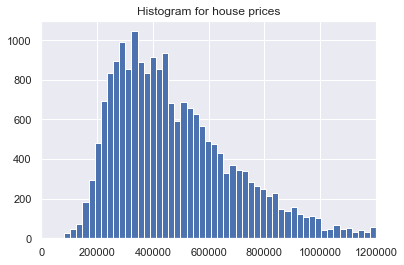

In [531]:
plt.hist(house_prices_cluster['price'], bins='auto')
plt.title("Histogram for house prices")
plt.xlim(xmin=0, xmax = 1200000)
plt.show()

In [532]:
mms = MinMaxScaler()
mms.fit(house_prices_cluster)
data_transformed = mms.transform(house_prices_cluster)

In [533]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

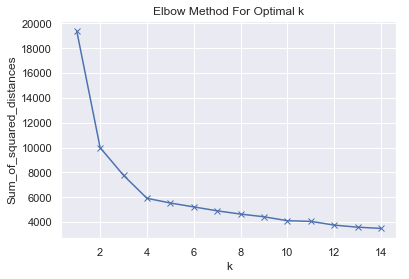

In [534]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [535]:
km = KMeans(n_clusters=4, random_state=1)
km.fit(house_prices_cluster)

KMeans(n_clusters=4, random_state=1)

In [536]:
predict=km.predict(house_prices_cluster)
house_prices_cluster['clusters'] = pd.Series(predict, index=house_prices_cluster.index)

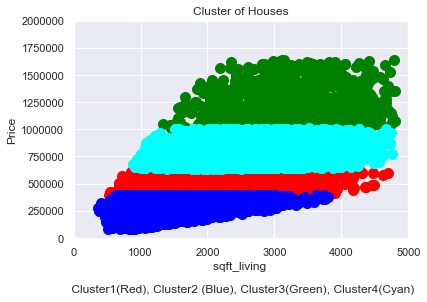

In [537]:
df_sub = house_prices_cluster[['sqft_living', 'price']].values

plt.scatter(df_sub[predict==0, 0], df_sub[predict==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(df_sub[predict==1, 0], df_sub[predict==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(df_sub[predict==2, 0], df_sub[predict==2, 1], s=100, c='green', label ='Cluster 3')
plt.scatter(df_sub[predict==3, 0], df_sub[predict==3, 1], s=100, c='cyan', label ='Cluster 4')

plt.title('Cluster of Houses')
plt.xlim((0, 5000))
plt.ylim((0,2000000))
plt.xlabel('sqft_living \n\n Cluster1(Red), Cluster2 (Blue), Cluster3(Green), Cluster4(Cyan)')
plt.ylabel('Price')
plt.show()

In [538]:
'''

Within the data set 4 clusters could be identified.

We can see in the graphic above that the target buyer groups of the houses can be clearly defined.

'''

'\n\nWithin the data set 4 clusters could be identified.\n\nWe can see in the graphic above that the target buyer groups of the houses can be clearly defined.\n\n'

## Reserach Question 3

In [539]:
'''

Does the number of square meters have a significant influence on the price of the property?

'''

'\n\nDoes the number of square meters have a significant influence on the price of the property?\n\n'

In [540]:
'''
To answer the research question we filter the data set for the variable price and sqft_living.
'''

HousePrices_SimplReg = final_df_house_prices[['price', 'sqft_living']]
HousePrices_SimplReg.head()

,price,sqft_living
0,221900,1180
1,538000,2570
2,180000,770
3,604000,1960
4,510000,1680


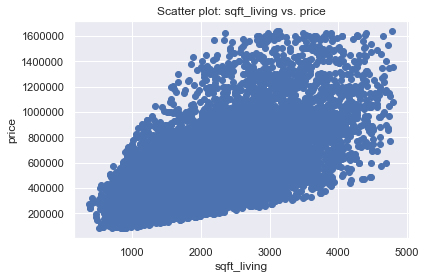

In [541]:
x = HousePrices_SimplReg['sqft_living']
y = HousePrices_SimplReg['price']

plt.scatter(x, y)
plt.title('Scatter plot: sqft_living vs. price')
plt.xlabel('sqft_living')
plt.ylabel('price')
plt.show()

In [542]:
model1 = smf.ols(formula='price~sqft_living', data=HousePrices_SimplReg).fit()

model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Fri, 06 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:36:52   Log-Likelihood:            -2.7752e+05
No. Observations:               20435   AIC:                         5.550e+05
Df Residuals:                   20433   BIC:                         5.551e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    8.605e+04   3717.483     23.147      0.000    7.88e+04    9.33e+04
sqft_living   207.2179      1.748    118.526      0.000     203.791     210.645
==============================================================================
Omnibus:                     3622.542   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7985.461
Skew:                           1.033   Prob(JB):                         0.00
Kurtosis:                       5.261   Cond. No.                     5.91e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [543]:
'''

As we can see from the p value, it is highly significant. 
It can therefore be assumed that the number of square meters is a 
significant predictor of the price of a property.

'''

'\n\nAs we can see from the p value, it is highly significant. \nIt can therefore be assumed that the number of square meters is a \nsignificant predictor of the price of a property.\n\n'

# Development of a Machine Learning Model - End to End Process

In [544]:
'''
Now that the descriptive part has been completed and the research questions 
posed at the beginning have been answered, we now come to the second main part of this publication.

The training of a machine learning model for predicting house prices. 

**A golden rule in Data Science**
For the development of a machine learning algorithm it is imperative that all pre-processing steps 
are applied to the training part only!
Anything else would negatively affect the later performance of the algorithm. 
Outliers are the only exceptions to this rule. Here it always depends on the respective data set and its size.

Often I have found that this rule is not followed. 
This has been one of the motivations for me to describe a complete end-to-end process 
for the development of machine learning models in this post.

The further procedure follows the Best Practice approach for ML Model Development. 
I have listed this approach at the end of this publication. 
It allows you to track the naming convention used and to see when which models, data sets or stored metrics are saved. 

'''

'\nNow that the descriptive part has been completed and the research questions \nposed at the beginning have been answered, we now come to the second main part of this publication.\n\nThe training of a machine learning model for predicting house prices. \n\n**A golden rule in Data Science**\nFor the development of a machine learning algorithm it is imperative that all pre-processing steps \nare applied to the training part only!\nAnything else would negatively affect the later performance of the algorithm. \nOutliers are the only exceptions to this rule. Here it always depends on the respective data set and its size.\n\nOften I have found that this rule is not followed. \nThis has been one of the motivations for me to describe a complete end-to-end process \nfor the development of machine learning models in this post.\n\nThe further procedure follows the Best Practice approach for ML Model Development. \nI have listed this approach at the end of this publication. \nIt allows you to tra

## Data pre-processing

In [545]:
'''
Due to the fact that we have to approach the pre-processing steps a bit differently to create an ML algorithm, 
we reload the original data set.
'''

house_prices = pd.read_csv("house_prices_dataframe.csv")
house_prices.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,property_typ
0,221900,3,1.00,1180,5650,1.0,no,bad,3,7.0,0,1955,0.0,apartment
1,538000,3,2.25,2570,7242,2.0,no,bad,3,7.0,400,1951,1991.0,semi_detached_house
2,180000,2,1.00,770,10000,1.0,no,bad,3,6.0,0,1933,NaN,apartment
3,604000,4,3.00,1960,5000,1.0,no,bad,5,7.0,910,1965,NaN,semi_detached_house
4,510000,3,2.00,1680,8080,1.0,no,bad,3,8.0,0,1987,0.0,apartment


### Train Test Split

In [546]:
x = house_prices.drop(['price'], axis=1)
y = house_prices['price']

trainX, testX, trainY, testY = train_test_split(x, y, test_size = 0.2)

In [547]:

'''
At this point it is recommended to reset the index of the 4 created 'records' and to delete 
the old index (which is automatically generated as new column).
'''

trainX = trainX.reset_index().drop(['index'], axis=1)
testX = testX.reset_index().drop(['index'], axis=1)
trainY = trainY.reset_index().drop(['index'], axis=1)
testY = testY.reset_index().drop(['index'], axis=1)

### Removal of outlier

In [548]:
# Define the outlier-detect function
def outliers_z_score(df):
    threshold = 3

    mean = np.mean(df)
    std = np.std(df)
    z_scores = [(y - mean) / std for y in df]
    return np.where(np.abs(z_scores) > threshold)

# For the further proceeding we just need numerical colunns
my_list = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_columns = list(trainX.select_dtypes(include=my_list).columns)
numerical_columns = trainX[num_columns]

# Now we are going to apply our outlier-function to all numerical columns
outlier_list = numerical_columns.apply(lambda x: outliers_z_score(x))
outlier_list

# Store the results within a dataframe
df_of_outlier = outlier_list.iloc[0]
df_of_outlier = pd.DataFrame(df_of_outlier)
df_of_outlier.columns = ['Rows_to_exclude']


# Convert all values from column Rows_to_exclude to a numpy array
outlier_list_final = df_of_outlier['Rows_to_exclude'].to_numpy()

# Concatenate a whole sequence of arrays
outlier_list_final = np.concatenate( outlier_list_final, axis=0 )

# Drop dubplicate values
outlier_list_final_unique = set(outlier_list_final)

# Create a new dataframe without the identified outlier
filter_rows_to_exclude = trainX.index.isin(outlier_list_final_unique)
trainX_wo_outlier = trainX[~filter_rows_to_exclude]

# Reset the index again 
trainX_wo_outlier = trainX_wo_outlier.reset_index().drop(['index'], axis=1)


In [549]:
print('Length of original dataframe: ' + str(len(trainX)))

print('Length of new dataframe without outliers: ' + str(len(trainX_wo_outlier)))
print('----------------------------------------------------------------------------------------------------')
print('Difference between new and old dataframe: ' + str(len(trainX) - len(trainX_wo_outlier)))
print('----------------------------------------------------------------------------------------------------')
print('Length of unique outlier list: ' + str(len(outlier_list_final_unique)))

Length of original dataframe: 17290
Length of new dataframe without outliers: 16468
----------------------------------------------------------------------------------------------------
Difference between new and old dataframe: 822
----------------------------------------------------------------------------------------------------
Length of unique outlier list: 822


In [550]:
'''
Of course it is now also necessary to remove the corresponding Y values of the outlier.
'''

filter_rows_to_exclude = trainY.index.isin(outlier_list_final_unique)
trainY_wo_outlier = trainY[~filter_rows_to_exclude]

trainY_wo_outlier = trainY_wo_outlier.reset_index().drop(['index'], axis=1)

In [551]:
print('Length of original dataframe: ' + str(len(trainY)))

print('Length of new dataframe without outliers: ' + str(len(trainY_wo_outlier)))
print('----------------------------------------------------------------------------------------------------')
print('Difference between new and old dataframe: ' + str(len(trainY) - len(trainY_wo_outlier)))
print('----------------------------------------------------------------------------------------------------')
print('Length of unique outlier list: ' + str(len(outlier_list_final_unique)))

Length of original dataframe: 17290
Length of new dataframe without outliers: 16468
----------------------------------------------------------------------------------------------------
Difference between new and old dataframe: 822
----------------------------------------------------------------------------------------------------
Length of unique outlier list: 822


### Missing Values

In [552]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

    
missing_values_table(trainX_wo_outlier)

Your selected dataframe has 13 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
yr_renovated,12672,76.9
grade,84,0.5


In [553]:
# Deletion of the column yr_renovated because too many missing values.

trainX_wo_outlier = trainX_wo_outlier.drop(['yr_renovated'], axis=1)

In [554]:
# Impute missing values for column grade with mean values of this columns

trainX_wo_outlier['grade'] = trainX_wo_outlier['grade'].fillna(trainX_wo_outlier['grade'].mean())

In [555]:
# Check if all missing values are removed or replaced.

missing_values_table(trainX_wo_outlier)

Your selected dataframe has 12 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [556]:
'''
Of course it can happen that the data we get later to the predicte also has some missing values. 
To be able to fill these values in a meaningful way it is advisable to save the corresponding metrics 
from the original trainings part (for example the average value of a column).
'''


mean_grade = trainX_wo_outlier['grade'].mean()
mean_condition = trainX_wo_outlier['condition'].mean()
mean_sqft_living = trainX_wo_outlier['sqft_living'].mean()
mean_sqft_lot = trainX_wo_outlier['sqft_lot'].mean()


pk.dump(mean_grade, open('metrics_MV/mean_grade.pkl', 'wb'))
pk.dump(mean_condition, open('metrics_MV/mean_condition.pkl', 'wb'))
pk.dump(mean_sqft_living, open('metrics_MV/mean_sqft_living.pkl', 'wb'))
pk.dump(mean_sqft_lot, open('metrics_MV/mean_sqft_lot.pkl', 'wb'))


print('Mean of column grade: ' + str(mean_grade))
print('Mean of column condition: ' + str(mean_condition))
print('Mean of column sqft_living: ' + str(mean_sqft_living))
print('Mean of column sqft_lot: ' + str(mean_sqft_lot))




Mean of column grade: 7.60247802734375
Mean of column condition: 3.4140150595093517
Mean of column sqft_living: 2002.1304955064368
Mean of column sqft_lot: 10607.543296089385


In [557]:
'''
To comply with the best practice approach, we assign a new name (trainX_wo_MV) to the data set (trainX_wo_outlier).
'''

trainX_wo_MV = trainX_wo_outlier

### Categorical Variables

In [558]:
obj_col = ['object']
object_columns = list(trainX_wo_MV.select_dtypes(include=obj_col).columns)
trainX_categorical = trainX_wo_MV[object_columns]

print()
print('There are ' + str(trainX_categorical.shape[1]) + ' categorical columns within dataframe(trainX).')


There are 3 categorical columns within dataframe(trainX).


In [559]:
'''
As we already know from the descriptive part, the three categorical variables are scaled as follows:

waterfront: binary
view: ordinal
property_typ: nominal

The variables will be coded accordingly in the following.

'''

'\nAs we already know from the descriptive part, the three categorical variables are scaled as follows:\n\nwaterfront: binary\nview: ordinal\nproperty_typ: nominal\n\nThe variables will be coded accordingly in the following.\n\n'

In [560]:
'''
In the following the column waterfront is coded.
Then the newly generated values are inserted into the original dataframe 
and the old column will be deleted. 
'''

encoder_waterfront = LabelBinarizer()

# Application of the LabelBinarizer
waterfront_encoded = encoder_waterfront.fit_transform(trainX_wo_MV.waterfront.values.reshape(-1,1))

# Insertion of the coded values into the original data set
trainX_wo_MV['waterfront_encoded'] = waterfront_encoded

# Delete the original column to avoid duplication
trainX_wo_MV = trainX_wo_MV.drop(['waterfront'], axis=1)

In [561]:
'''
In the following the column view is coded.
Instead of the OrdinalEncoder from scikit learn I prefer to use a dictionary, 
because I can specify the exact ordinal order here.
I also design an inverse dictionary to encode the data back later if needed. 

Then the newly generated values are inserted into the original dataframe 
and the old column will be deleted. 

'''

# Create a dictionary how the observations should be coded
view_dict = {'bad' : 0,
             'medium' : 1,
             'good' : 2,
             'very_good' : 3,
             'excellent' : 4}

view_dict_inverse = {0 : 'bad',
                     1 : 'medium',
                     2 : 'good',
                     3 : 'very_good',
                     4 : 'excellent'}


# Map the dictionary on the column view and store the results in a new column
trainX_wo_MV['view_encoded'] = trainX_wo_MV.view.map(view_dict)

# Delete the original column to avoid duplication
trainX_wo_MV = trainX_wo_MV.drop(['view'], axis=1)

In [562]:
'''
In the following the column property_typ is coded.
Then the newly generated values are inserted into the original dataframe 
and the old column will be deleted. 
'''

encoder_property_typ = OneHotEncoder()

# Application of the OneHotEncoder
OHE = encoder_property_typ.fit_transform(trainX_wo_MV.property_typ.values.reshape(-1,1)).toarray()

# Conversion of the newly generated data to a dataframe
df_OHE = pd.DataFrame(OHE, columns = ["property_typ_" + str(encoder_property_typ.categories_[0][i]) 
                                     for i in range(len(encoder_property_typ.categories_[0]))])




# Insertion of the coded values into the original data set
trainX_wo_MV = pd.concat([trainX_wo_MV, df_OHE], axis=1)


# Delete the original column to avoid duplication
trainX_wo_MV = trainX_wo_MV.drop(['property_typ'], axis=1)



In [563]:
'''
An often forgotten step but a very important necessity is to store the fitted encoders or used 
dictionaries separately to be able to use them after deployment for predictions on new data.

'''

pk.dump(encoder_waterfront, open('encoder/encoder_waterfront.pkl', 'wb'))
pk.dump(view_dict, open('encoder/view_dict.pkl', 'wb'))
pk.dump(view_dict_inverse, open('encoder/view_dict_inverse.pkl', 'wb'))
pk.dump(encoder_property_typ, open('encoder/encoder_property_typ.pkl', 'wb'))


print('Classes of encoder_waterfront :')
print(encoder_waterfront.classes_)
print('Codierung: no=0, yes=1')
print()
print('------------------------------------------------')
print()
print('Assignments by the dictionary for view :')
print(view_dict)
print()
print('------------------------------------------------')
print()
print('Assignments by the inverse dictionary for view :')
print(view_dict_inverse)
print()
print('------------------------------------------------')
print()
print('Categories of encoder_property_typ :')
print(encoder_property_typ.categories_)
print()



Classes of encoder_waterfront :
['no' 'yes']
Codierung: no=0, yes=1

------------------------------------------------

Assignments by the dictionary for view :
{'bad': 0, 'medium': 1, 'good': 2, 'very_good': 3, 'excellent': 4}

------------------------------------------------

Assignments by the inverse dictionary for view :
{0: 'bad', 1: 'medium', 2: 'good', 3: 'very_good', 4: 'excellent'}

------------------------------------------------

Categories of encoder_property_typ :
[array(['apartment', 'multi_generation_house', 'semi_detached_house',
       'single_family_house', 'top_floor_apartment'], dtype=object)]



In [564]:
'''
Once again we keep to the naming convention and adhere to the requirement to save the currently created data set. 

'''


trainX_encoded = trainX_wo_MV

trainX_encoded.to_csv('dataframes/trainX_encoded.csv', index=False)

### Scaling

In [565]:
'''
Another important pre-processing step is the scaling of the data. We will apply the standard scaler to the 
trainX_wo_outlier data set and save the fitted scaler for later transformations. 

'''

col_names = trainX_encoded.columns
features = trainX_encoded[col_names]

scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

trainX_scaled = pd.DataFrame(features, columns = col_names)
trainX_scaled.head()



,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_basement,yr_built,waterfront_encoded,view_encoded,property_typ_apartment,property_typ_multi_generation_house,property_typ_semi_detached_house,property_typ_single_family_house,property_typ_top_floor_apartment
0,-1.553844,-1.514132,-1.045542,-0.633651,-0.907739,-0.642628,-0.560900,-0.074137,-2.097637,-0.080489,1.106857,-1.243887,-0.085676,1.458096,-0.249492,-0.082750
1,-0.390510,-1.514132,-1.249021,-0.435625,-0.907739,-0.642628,-0.560900,-0.673371,-0.908494,-0.080489,-0.289475,0.803932,-0.085676,-0.685826,-0.249492,-0.082750
2,-2.717178,-1.514132,-1.630545,-0.420622,-0.907739,0.909557,-1.491889,-0.673371,-2.131612,-0.080489,-0.289475,-1.243887,-0.085676,-0.685826,-0.249492,12.084524
3,-1.553844,-0.452086,-1.439783,-0.495633,-0.907739,-0.642628,-1.491889,-0.673371,-1.010420,-0.080489,-0.289475,0.803932,-0.085676,-0.685826,-0.249492,-0.082750
4,-0.390510,-0.098070,-0.244341,0.005735,0.949467,-0.642628,0.370088,-0.673371,0.552453,-0.080489,-0.289475,0.803932,-0.085676,-0.685826,-0.249492,-0.082750


In [566]:
'''
As announced also this scaler is stored for later predictions.
'''

pk.dump(scaler, open('scaler/StandardScaler.pkl', 'wb'))

## Filter Methods

### Dealing with highly correlated features

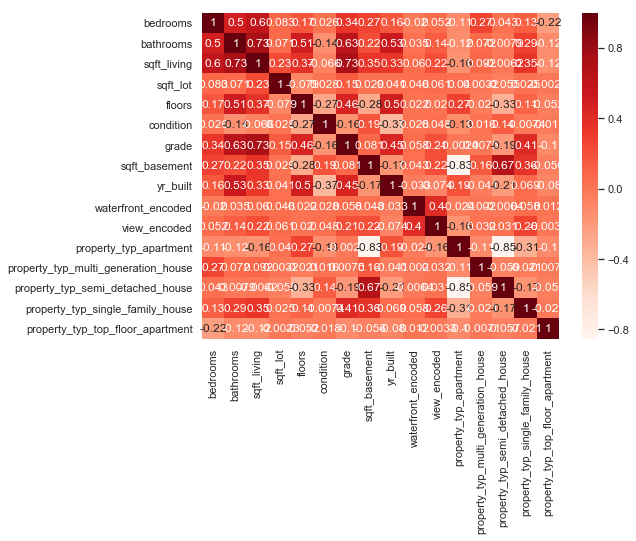

In [567]:
'''
Now that all variables are numeric it is easy to create a correlation plot. 
This gives a first insight into which variables seem to correlate highly. 
'''

plt.figure(figsize=(8,6))
cor = trainX_scaled.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [568]:
'''
With the following commands I check if highly correlated variables exist. 
If so, we would have to exclude them, since this is a prerequisite for regression analysis. 
As we can see, this is not the case here.
'''

correlated_features = set()
correlation_matrix = trainX_scaled.corr()

threshold = 0.90

for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
            
len(correlated_features)

0

### Dealing with constant features

In [569]:
'''
It is as important as the highly correlated variables to check 
whether constant features or quasi constant features exist.

Also this is not the case here. No further variables must be excluded.

'''

constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(trainX_scaled)


constant_columns = [column for column in trainX_scaled.columns
                    if column not in trainX_scaled.columns[constant_filter.get_support()]]




qconstant_filter = VarianceThreshold(threshold=0.01)
qconstant_filter.fit(trainX_scaled)


qconstant_columns = [column for column in trainX_scaled.columns
                    if column not in trainX_scaled.columns[qconstant_filter.get_support()]]



print('Number of constant features: ' + str(len(constant_columns)))
print('Number of constant features: ' + str(len(qconstant_columns)))


Number of constant features: 0
Number of constant features: 0


### Dealing with Duplicate Features

In [570]:
'''
Finally we check if duplicated features exist.

This is also not the case.
'''

trainX_scaled_T = trainX_scaled.T

print('Number of duplicate features: ' + str(trainX_scaled_T.duplicated().sum()))


Number of duplicate features: 0


In [571]:
'''
Due to the fact that we did not have to exclude any other features, 
the following two training data sets are the ones we want to continue working with:

'''

trainX_final = trainX_scaled
trainY_final = trainY_wo_outlier

'''
Furthermore, the respective final data sets are also to be stored at this point.
'''

trainX_final.to_csv('dataframes/trainX_final.csv', index=False)
trainY_final.to_csv('dataframes/trainY_final.csv', index=False)

## ML-Model Development

### Training

In [572]:
'''
Subsequently, the regression model is created, trained and its R² value is calculated.

It is also stored for test purposes and validation.
'''

lm = LinearRegression()
lm.fit(trainX_final, trainY_final)

print('R² Score of fitted lm-model: ' + str(lm.score(trainX_final, trainY_final)))

pk.dump(lm, open('model/lm_model.pkl', 'wb'))

R² Score of fitted lm-model: 0.6236883814477103


### Testing

In [573]:
'''
You can consider the test data set as a completely independent new data set on which to make predictions. 

This means that we have to do all pre-processing steps (coding, scaling, removing columns etc.) again. 

This is a step that is a bit more complex and is avoided by many developers by first pre-processing 
the data and then doing a train-test split, but it is the closest to the truth. 

Now we will also need most of the previously saved files (saved mean values, scalers etc.).
'''

'\nYou can consider the test data set as a completely independent new data set on which to make predictions. \n\nThis means that we have to do all pre-processing steps (coding, scaling, removing columns etc.) again. \n\nThis is a step that is a bit more complex and is avoided by many developers by first pre-processing \nthe data and then doing a train-test split, but it is the closest to the truth. \n\nNow we will also need most of the previously saved files (saved mean values, scalers etc.).\n'

#### Missing Values

In [574]:
'''
We know from the previous analysis that we excluded the column yr_renovated 
because of the high number of missing values.

We also know that the column grade also contains missing values 
and we should fill it with the stored mean_grade.

We will do this in the following.

Outliers are no longer identified and excluded, as it is now the test data set. 
'''


# Deletion of the column yr_renovated because too many missing values.
testX = testX.drop(['yr_renovated'], axis=1)

# Impute missing values for column grade with with the average values of this column from the training data set.
mean_grade_reload = pk.load(open("metrics_MV/mean_grade.pkl",'rb'))
testX['grade'] = testX['grade'].fillna(mean_grade_reload)

# Rename testX according best practice guideline
testX_wo_MV = testX

#### Categorical Variables

In [575]:
'''
We also know from the past which variables are categorical and how they must be coded accordingly.
This time we only use the saved encoders and the saved dictionaries.

Watch out!

With the loaded encoder only the transform function will be used from now on. 
In no case the fit_transform function is used, because otherwise new values would be generated. 

'''

# Load the necessary encoder/dic
encoder_waterfront_reload = pk.load(open("encoder/encoder_waterfront.pkl",'rb'))
view_dict_reload = pk.load(open("encoder/view_dict.pkl",'rb'))
encoder_property_typ_reload = pk.load(open("encoder/encoder_property_typ.pkl",'rb'))



# Application of the reload LabelBinarizer
waterfront_encoded = encoder_waterfront_reload.transform(testX_wo_MV.waterfront.values.reshape(-1,1))
# Insertion of the coded values into the original data set
testX_wo_MV['waterfront_encoded'] = waterfront_encoded
# Delete the original column to avoid duplication
testX_wo_MV = testX_wo_MV.drop(['waterfront'], axis=1)


# Map the reload dictionary on the column view and store the results in a new column
testX_wo_MV['view_encoded'] = testX_wo_MV.view.map(view_dict_reload)
# Delete the original column to avoid duplication
testX_wo_MV = testX_wo_MV.drop(['view'], axis=1)



# Application of the reload OneHotEncoder
OHE = encoder_property_typ_reload.transform(testX_wo_MV.property_typ.values.reshape(-1,1)).toarray()
# Conversion of the newly generated data to a dataframe
df_OHE = pd.DataFrame(OHE, columns = ["property_typ_" + str(encoder_property_typ_reload.categories_[0][i]) 
                                      for i in range(len(encoder_property_typ_reload.categories_[0]))])
# Insertion of the coded values into the original data set
testX_wo_MV = pd.concat([testX_wo_MV, df_OHE], axis=1)
# Delete the original column to avoid duplication
testX_wo_MV = testX_wo_MV.drop(['property_typ'], axis=1)

In [576]:
'''
At this point we will rename the data set accordingly and also save it separately.
'''


# Rename testX_wo_MV according best practice guideline
testX_encoded = testX_wo_MV


testX_encoded.to_csv('dataframes/testX_encoded.csv', index=False)

#### Scaling

In [577]:
'''
Like the coding, the testX data must be scaled using the same metrics calculated from the training data. 
'''

# Load the necessary scaler
scaler_reload = pk.load(open("scaler/StandardScaler.pkl",'rb'))


col_names = testX_encoded.columns
features = testX_encoded[col_names]

features = scaler_reload.transform(features.values)
testX_scaled = pd.DataFrame(features, columns = col_names)


In [578]:
'''
Since we did not find any variables in the filter methods, we have to exclude them, 
this step is skipped in the test data.

However, we still rename the data sets accordingly and store them separately.


'''

testX_final = testX_scaled
testY_final = testY

testX_final.to_csv('dataframes/testX_final.csv', index=False)
testY_final.to_csv('dataframes/testY_final.csv', index=False)

#### Test the ML-Model

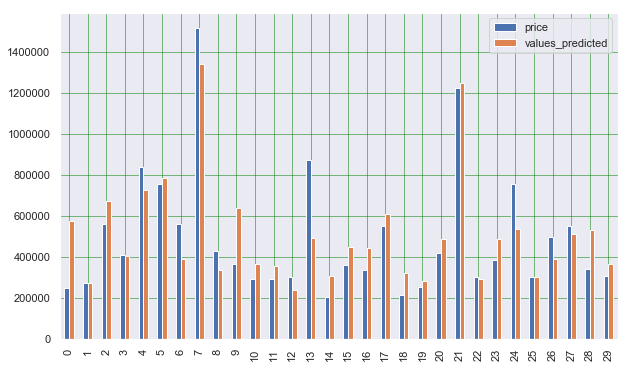

Mean Absolute Error: 132699.12118692521
Mean Squared Error: 42988782446.29574
Root Mean Squared Error: 207337.36384524556


In [579]:
'''
Now it is time to test the saved lm model. For this we reload it and predicted the house prices.

In the following an evaluation will take place.
'''

# Reload the model
lm_reload = pk.load(open("model/lm_model.pkl",'rb'))

# Predict values for test dataset
y_pred = lm_reload.predict(testX_final)



y_pred_df = pd.DataFrame(y_pred)
y_pred_df.columns = ['values_predicted']
actual_vs_predicted = pd.concat([testY_final, y_pred_df], axis=1)

df1 = actual_vs_predicted.head(30)
df1.plot(kind='bar',figsize=(10,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()


print('Mean Absolute Error:', metrics.mean_absolute_error(testY_final, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(testY_final, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testY_final, y_pred)))

## Feature Selection

In [580]:
'''

Now that we have successfully developed a ml model, 
we try to improve it again by selecting only the most important features (via RFE).


'''

'\n\nNow that we have successfully developed a ml model, \nwe try to improve it again by selecting only the most important features (via RFE).\n\n\n'

### Recursive Feature Elimination

In [581]:
lr = LinearRegression()

rfe = RFE(lr, n_features_to_select=10)
rfe.fit(trainX_final, trainY_final)

RFE(estimator=LinearRegression(), n_features_to_select=10)

In [582]:
Columns = trainX_final.columns
RFE_support = rfe.support_
RFE_ranking = rfe.ranking_

dataset = pd.DataFrame({'Columns': Columns, 'RFE_support': RFE_support, 'RFE_ranking': RFE_ranking}, columns=['Columns', 'RFE_support', 'RFE_ranking'])
dataset

,Columns,RFE_support,RFE_ranking
0,bedrooms,True,1
1,bathrooms,True,1
2,sqft_living,True,1
3,sqft_lot,False,4
4,floors,False,2
5,condition,False,3
6,grade,True,1
7,sqft_basement,True,1
8,yr_built,True,1
9,waterfront_encoded,True,1


In [583]:
df = dataset[(dataset["RFE_support"] == True) & (dataset["RFE_ranking"] == 1)]
filtered_features = df['Columns']
filtered_features

0                             bedrooms
1                            bathrooms
2                          sqft_living
6                                grade
7                        sqft_basement
8                             yr_built
9                   waterfront_encoded
10                        view_encoded
11              property_typ_apartment
14    property_typ_single_family_house
Name: Columns, dtype: object

In [584]:
pk.dump(filtered_features, open('feature_selection_RFE/filtered_features_RFE.pkl', 'wb'))

### Training

In [585]:
'''
Due to the fact that we will now consider a new number of variables, 
we have to reapply and save the scaler. If we don't do that, 
we will have problems later on to transform the data back to make it readable. 
The scaler remembers the number of columns and the order of the columns.

For example, you can not scale 5 columns and only try to transform 4 back. 
If you take this into account in the preparation, you often save yourself additional work later.  

For this step we reload the anticipatory stored data set trainX_encoded, apply the filter from 
feature selection RFE (filtered_features_RFE) to it and rescale it (and of course save the new scaler again).

'''

trainX_encoded_reload = pd.read_csv("dataframes/trainX_encoded.csv")
trainX_encoded_reload.head()





,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_basement,yr_built,waterfront_encoded,view_encoded,property_typ_apartment,property_typ_multi_generation_house,property_typ_semi_detached_house,property_typ_single_family_house,property_typ_top_floor_apartment
0,2,1.00,1180,2160,1.0,3,7.0,240,1909,0,1,0.0,0.0,1.0,0.0,0.0
1,3,1.00,1020,4800,1.0,3,7.0,0,1944,0,0,1.0,0.0,0.0,0.0,0.0
2,1,1.00,720,5000,1.0,4,6.0,0,1908,0,0,0.0,0.0,0.0,0.0,1.0
3,2,1.75,870,4000,1.0,3,6.0,0,1941,0,0,1.0,0.0,0.0,0.0,0.0
4,3,2.00,1810,10684,2.0,3,8.0,0,1987,0,0,1.0,0.0,0.0,0.0,0.0


#### Column selection according RFE

In [586]:
'''
As announced shortly before, we load the filter from RFE and apply it.
'''

filtered_features_RFE_reload = pk.load(open("feature_selection_RFE/filtered_features_RFE.pkl",'rb'))

trainX_FS = trainX_encoded_reload[filtered_features_RFE_reload]

#### New Scaling

In [587]:


col_names = trainX_FS.columns
features = trainX_FS[col_names]

scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

trainX_FS_scaled = pd.DataFrame(features, columns = col_names)



pk.dump(scaler, open('scaler/StandardScaler2.pkl', 'wb'))


In [588]:
'''
As a last step, we rename the data sets for x and y again and save them.
'''

trainX_final2 = trainX_FS_scaled
trainY_final2 = trainY_final

trainX_final2.to_csv('dataframes/trainX_final2.csv', index=False)
trainY_final2.to_csv('dataframes/trainY_final2.csv', index=False)


#### Fit the new model

In [589]:
'''
Here a new training starts due to the data situation after feature selection.
 
'''

lm2 = LinearRegression()
lm2.fit(trainX_final2, trainY_final2)

print('R² Score of fitted lm2-model: ' + str(lm2.score(trainX_final2, trainY_final2)))

pk.dump(lm2, open('model/lm2_model.pkl', 'wb'))

R² Score of fitted lm2-model: 0.6180856987277279


### Testing

In [590]:
'''
As in the training part after RFE we have to select the column via the RFE filter and rescale it.
'''

testX_encoded_reload = pd.read_csv("dataframes/testX_encoded.csv")
testX_encoded_reload.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_basement,yr_built,waterfront_encoded,view_encoded,property_typ_apartment,property_typ_multi_generation_house,property_typ_semi_detached_house,property_typ_single_family_house,property_typ_top_floor_apartment
0,5,1.75,2140,12058,1.0,4,8.0,0,1951,0,0,1.0,0.0,0.0,0.0,0.0
1,3,1.00,1130,8100,1.5,3,6.0,0,1934,0,0,1.0,0.0,0.0,0.0,0.0
2,3,2.50,2780,32880,1.0,3,9.0,0,1993,0,0,1.0,0.0,0.0,0.0,0.0
3,2,1.75,1480,4000,1.0,4,6.0,740,1925,0,0,0.0,0.0,1.0,0.0,0.0
4,3,2.50,2060,9715,2.0,3,8.0,0,1924,0,0,1.0,0.0,0.0,0.0,0.0


#### Column selection according RFE

In [591]:
'''
As announced shortly before, we load the filter from RFE and apply it.
'''

filtered_features_RFE_reload = pk.load(open("feature_selection_RFE/filtered_features_RFE.pkl",'rb'))

testX_FS = testX_encoded_reload[filtered_features_RFE_reload]

#### New Scaling

In [592]:
'''
Like the coding, the testX data must be scaled using the same metrics calculated from the training data. 
'''

# Load the necessary scaler
scaler2_reload = pk.load(open("scaler/StandardScaler2.pkl",'rb'))


col_names = testX_FS.columns
features = testX_FS[col_names]

features = scaler2_reload.transform(features.values)

testX_FS_scaled = pd.DataFrame(features, columns = col_names)

In [593]:


testX_final2 = testX_FS_scaled
testY_final2 = testY_final

testX_final2.to_csv('dataframes/testX_final.csv', index=False)
testY_final2.to_csv('dataframes/testY_final.csv', index=False)



#### Test the new ML-Model

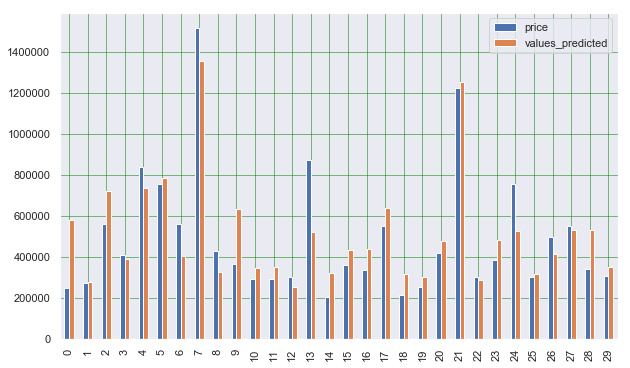

Mean Absolute Error: 132039.4073285654
Mean Squared Error: 42255376355.634705
Root Mean Squared Error: 205561.12559439515


In [594]:
'''
Now we will test the newly created lm model (based on feature selection). 
'''

# Reload the model
lm2_reload = pk.load(open("model/lm2_model.pkl",'rb'))

# Predict values for test dataset
y_pred = lm2_reload.predict(testX_final2)



y_pred_df = pd.DataFrame(y_pred)
y_pred_df.columns = ['values_predicted']
actual_vs_predicted = pd.concat([testY_final2, y_pred_df], axis=1)

df1 = actual_vs_predicted.head(30)
df1.plot(kind='bar',figsize=(10,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()


print('Mean Absolute Error:', metrics.mean_absolute_error(testY_final2, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(testY_final2, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testY_final2, y_pred)))

In [ ]:
'''
As we can see from the Mean Absolut Error (MAE), the lm2 model has improved slightly compared to the first model. 

The same applies to the Mean Squared Error as well as Root Mean Squared Error.

At this point we now have completely prepared training and test data on 
which the performance of various algorithms can be tested. 
My recommendation at this point is to always start with 'simple' algorithms 
(like the linear regression model) and then to use more 
and more complex algorithms (random forest, ensemble methods up to neural networks).

Furthermore you can use hyperparameter tuning (with grid-search) to improve the performance. 

As we have seen, the data preprocessing has taken the most time. Now comes the best part, 
the magic with different machnie learning models. 
'''

## Out-Of-The-Box-Data

In [622]:
'''
So far we have prepared the data accordingly, developed a machine learning model and improved it using feature selection.
Now we can test it again with completely new data. 

This is, for example, the description of the property I am currently living in. 
I am curious to see what value is predicted for my property. 
'''

my_property = pd.DataFrame({
                   'bedrooms': [3],
                   'bathrooms': [2],
                   'sqft_living': [180],
                   'sqft_lot': [1300],
                   'floors': [2],
                   'waterfront': ['yes'],
                   'view': ['good'],
                   'condition': [np.NaN],
                   'grade': [4],
                   'sqft_basement': [300],
                   'yr_built': [1950],
                   'yr_renovated': [2001],
                   'property_typ': ['apartment']})
my_property

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,property_typ
0,3,2,180,1300,2,yes,good,NaN,4,300,1950,2001,apartment


### Missing Values

In [623]:
'''
First I replace all missing values again. This time the columned condition is filled with NaN and will be replaced by me.
'''

# Deletion of the column yr_renovated because too many missing values.
my_property = my_property.drop(['yr_renovated'], axis=1)

# Impute missing values for column condition with with the average values of this column from the training data set.
mean_condition_reload = pk.load(open("metrics_MV/mean_condition.pkl",'rb'))
my_property['condition'] = my_property['condition'].fillna(mean_condition_reload)

my_property_wo_MV = my_property

### Cat Var

In [624]:
'''
As known, the coding of the categorical variables is also carried out. 
'''

# Load the necessary encoder/dic
encoder_waterfront_reload = pk.load(open("encoder/encoder_waterfront.pkl",'rb'))
view_dict_reload = pk.load(open("encoder/view_dict.pkl",'rb'))
encoder_property_typ_reload = pk.load(open("encoder/encoder_property_typ.pkl",'rb'))



# Application of the reload LabelBinarizer
waterfront_encoded = encoder_waterfront_reload.transform(my_property_wo_MV.waterfront.values.reshape(-1,1))
# Insertion of the coded values into the original data set
my_property_wo_MV['waterfront_encoded'] = waterfront_encoded
# Delete the original column to avoid duplication
my_property_wo_MV = my_property_wo_MV.drop(['waterfront'], axis=1)


# Map the reload dictionary on the column view and store the results in a new column
my_property_wo_MV['view_encoded'] = my_property_wo_MV.view.map(view_dict_reload)
# Delete the original column to avoid duplication
my_property_wo_MV = my_property_wo_MV.drop(['view'], axis=1)



# Application of the reload OneHotEncoder
OHE = encoder_property_typ_reload.transform(my_property_wo_MV.property_typ.values.reshape(-1,1)).toarray()
# Conversion of the newly generated data to a dataframe
df_OHE = pd.DataFrame(OHE, columns = ["property_typ_" + str(encoder_property_typ_reload.categories_[0][i]) 
                                      for i in range(len(encoder_property_typ_reload.categories_[0]))])
# Insertion of the coded values into the original data set
my_property_wo_MV = pd.concat([my_property_wo_MV, df_OHE], axis=1)
# Delete the original column to avoid duplication
my_property_wo_MV = my_property_wo_MV.drop(['property_typ'], axis=1)


my_property_encoded = my_property_wo_MV

### Column selection according RFE

In [625]:
'''
Next we are going to do the column selection according RFE
'''

filtered_features_RFE_reload = pk.load(open("feature_selection_RFE/filtered_features_RFE.pkl",'rb'))

my_property_encoded = my_property_encoded[filtered_features_RFE_reload]


my_property_FS = my_property_encoded

### Scaling

In [626]:
'''
Last but not least feature scaling.
'''

# Load the necessary scaler
scaler2_reload = pk.load(open("scaler/StandardScaler2.pkl",'rb'))


col_names = my_property_FS.columns
features = my_property_FS[col_names]

features = scaler2_reload.transform(features.values)

my_property_FS_scaled = pd.DataFrame(features, columns = col_names)








### Prediction of new Values

In [627]:
'''
Now I will use the final created model to predict the price for my property.
'''

# Reload the model
lm2_reload = pk.load(open("model/lm2_model.pkl",'rb'))

# Predict values for my dataset
y_pred = lm2_reload.predict(my_property_FS_scaled)

print('The predicted price for my property is: ' + str(y_pred))

The predicted price for my property is: [[431023.17945913]]


# Conclusion

In [628]:
'''
In this publication I have shown how to prepare data in a meaningful way to 
extract valuable insights (answers to research questions). 
I also covered all steps of developing and evaluating a machine learning model. 


Here is an overview how I proceeded with the development of a machine learning model:

**Data pre-processing**
+ Outliers
+ Missing Values
+ Feature Encoding
+ Feature Scaling

**Filter Methods**
+ Highly correlated features
+ Constant features
+ Duplicate features


**Model Traing & Testing**
+ Simple Models (eg. linear Regression)
+ More Complex Models (eg. Random Forest / Neural Networks)
+ Hyperparameter Tuning


**Feature Selection**
+ Slect K Best
+ RFE
+ ...

At this point the training and testing of the algorithms starts again. 

**Model Evaluation**
As soon as an ML-model is created and tested I save the model and its performance metrics. 
This allows me to compare the models with each other later and I can take out the model with the best performance. 


'''

'\nIn this publication I have shown how to prepare data in a meaningful way to \nextract valuable insights (answers to research questions). \nI also covered all steps of developing and evaluating a machine learning model. \n\n\nHere is an overview how I proceeded with the development of a machine learning model:\n\n**Data pre-processing**\n+ Outliers\n+ Missing Values\n+ Feature Encoding\n+ Feature Scaling\n\n**Filter Methods**\n+ Highly correlated features\n+ Constant features\n+ Duplicate features\n\n\n**Model Traing & Testing**\n+ Simple Models (eg. linear Regression)\n+ More Complex Models (eg. Random Forest / Neural Networks)\n+ Hyperparameter Tuning\n\n\n**Feature Selection**\n+ Slect K Best\n+ RFE\n+ ...\n\nAt this point the training and testing of the algorithms starts again. \n\n**Model Evaluation**\nAs soon as an ML-model is created and tested I save the model and its performance metrics. \nThis allows me to compare the models with each other later and I can take out the mode

# Data Science Best Practice Guidlines for ML Model Development

In [ ]:
'''
Simple Development
Development with Filter Methods
Development with Feature Selection
Development with Filter Method and Feature Selection

'''

# Limitations

In [ ]:
'''

No statistical linear model was created to find out which predictors are significant.
No further machine learning algorithms were trained for regression problems including hypter parameter tuning and tested to see if they might offer better performance.
Not for all predictors average values (for later use) were saved.

'''